In [1]:
from preprocess_data import split_dataset_by_class

split_dataset_by_class(
    source_dir='data',
    output_base_dir='maize_leaf_split_dataset',
    split_ratios=(0.9, 0.05, 0.05)
) 

Copying Test images for 'Healthy': 100%|██████████| 59/59 [00:00<00:00, 78.12it/s]


 Dataset split completed!


In [10]:
from preprocess_data import get_class_distribution
train_dir = 'maize_leaf_split_dataset/Train'
valid_dir = 'maize_leaf_split_dataset/Valid'
test_dir = 'maize_leaf_split_dataset/Test'


print(f"Class distribution in the training set: {get_class_distribution(train_dir)}")
print(f"Class distribution in the validation set: {get_class_distribution(valid_dir)}")
print(f"Class distribution in the test set: {get_class_distribution(test_dir)}")

Class distribution in the training set: {'Blight': 515, 'Common_Rust': 515, 'Gray_Leaf_Spot': 515, 'Healthy': 515}
Class distribution in the validation set: {'Blight': 57, 'Common_Rust': 65, 'Gray_Leaf_Spot': 28, 'Healthy': 58}
Class distribution in the test set: {'Blight': 58, 'Common_Rust': 66, 'Gray_Leaf_Spot': 30, 'Healthy': 59}



Class: Blight


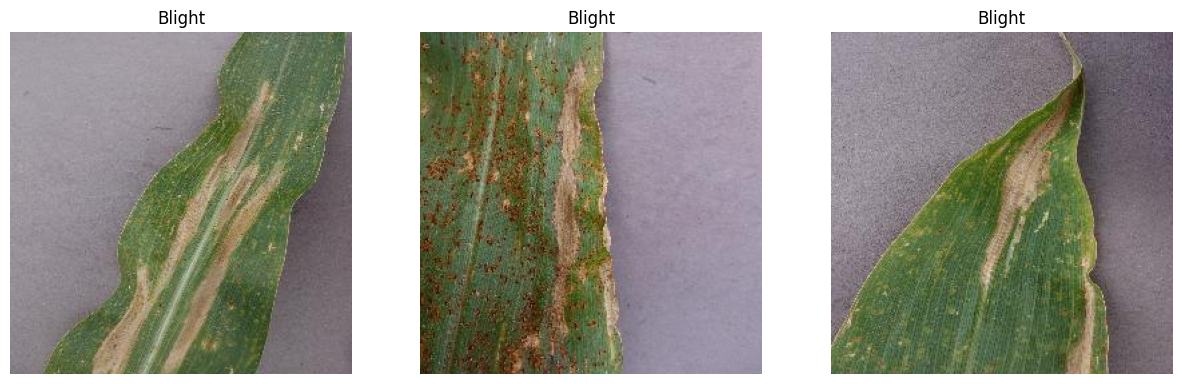


Class: Common_Rust


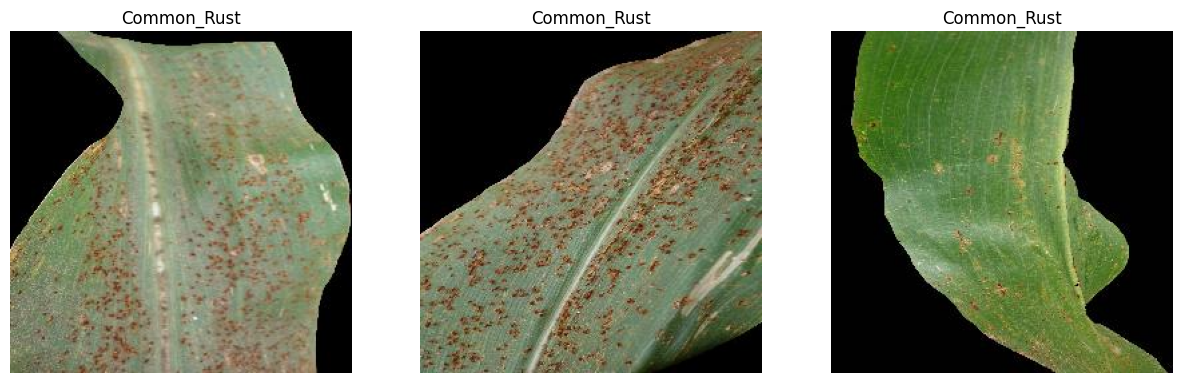


Class: Gray_Leaf_Spot


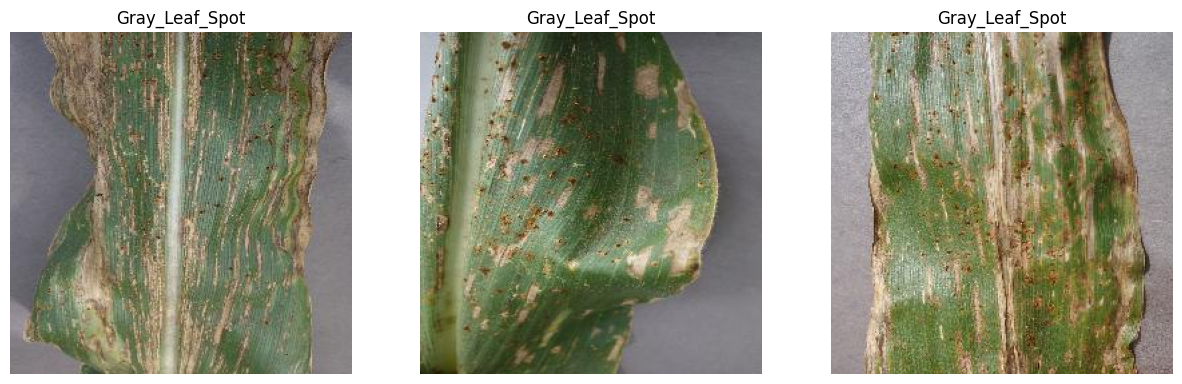


Class: Healthy


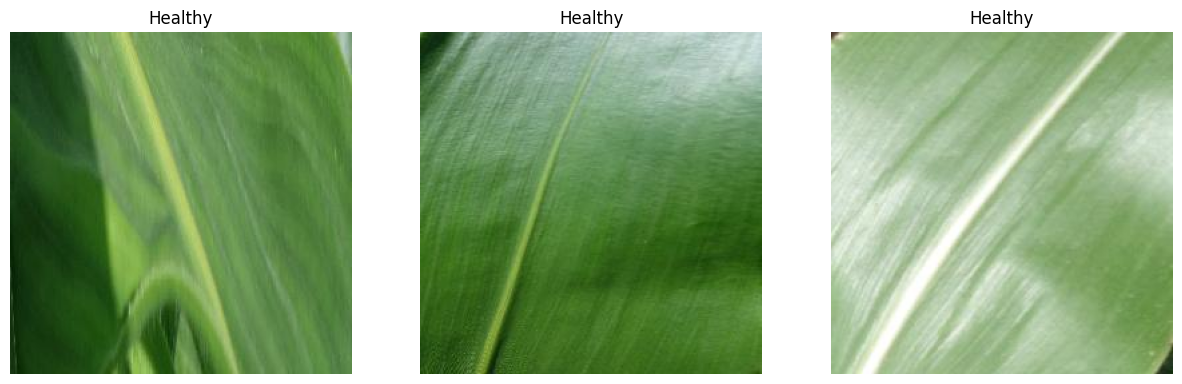

In [11]:
from visualize_downsample import visualize_samples, plot_class_distribution, drop_images

visualize_samples(train_dir, num_samples=3)

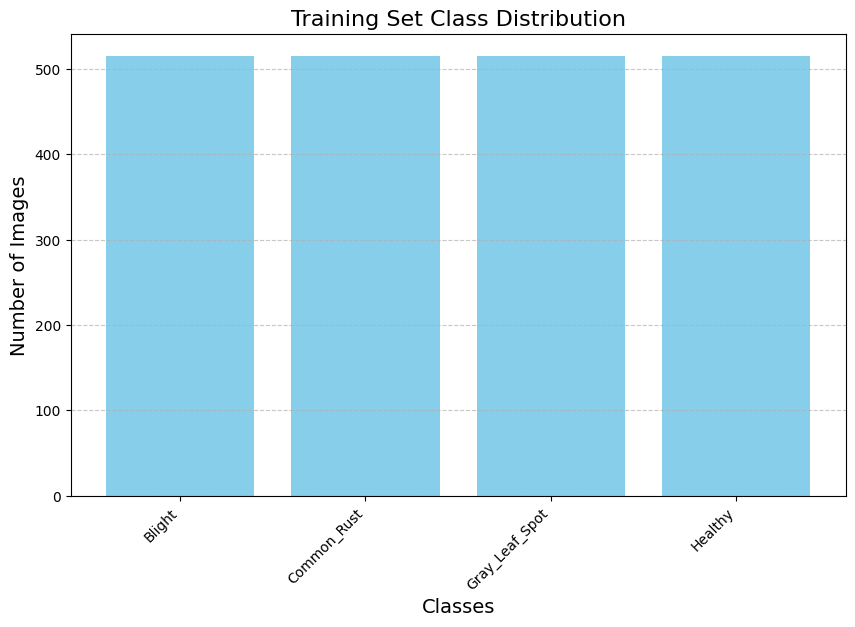

In [12]:
plot_class_distribution(get_class_distribution(train_dir), title='Training Set Class Distribution')

In [ ]:
from load_data import create_dataloaders

train_dir = 'maize_leaf_split_dataset/Train'
valid_dir = 'maize_leaf_split_dataset/Valid'
test_dir = 'maize_leaf_split_dataset/Test'

train_loader, valid_loader, test_loader = create_dataloaders(
    train_dir=train_dir,
    valid_dir=valid_dir,
    test_dir=test_dir,
    batch_size=32,
)

In [2]:
from model_builder import load_model
model = load_model(num_labels=4)

c:\Users\ACER NITRO 5\Desktop\Capstone Project\capstone_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import wandb

wandb.init(
    project="maize-leaf-disease-identification",
    name="vit-training-run",
    config={
        "epochs": 10,
        "batch_size": 32,
        "optimizer": "Adam",
        "architecture": "ViT-base-patch16-224"
        }
    )

wandb: Currently logged in as: ufee (ufee-gsu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
from train_validate_save_model import train_and_validate
from torch import nn
from torch import optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

train_and_validate(model=model, trainloader=train_loader, validloader=valid_loader, criterion=criterion, optimizer=optimizer, device=device, epochs=10)


Epoch 1/10 | Train Loss: 0.5759 | Train Acc: 78.88% | Val Loss: 0.2813 | Val Acc: 88.26%
Epoch 2/10 | Train Loss: 0.3278 | Train Acc: 87.72% | Val Loss: 0.2786 | Val Acc: 88.26%
Epoch 3/10 | Train Loss: 0.3004 | Train Acc: 88.50% | Val Loss: 0.2320 | Val Acc: 89.67%
Epoch 4/10 | Train Loss: 0.2728 | Train Acc: 90.39% | Val Loss: 0.2104 | Val Acc: 91.55%
Epoch 5/10 | Train Loss: 0.2493 | Train Acc: 91.94% | Val Loss: 0.2131 | Val Acc: 90.61%
Epoch 6/10 | Train Loss: 0.2412 | Train Acc: 91.12% | Val Loss: 0.2041 | Val Acc: 91.08%
Epoch 7/10 | Train Loss: 0.2277 | Train Acc: 91.60% | Val Loss: 0.2106 | Val Acc: 92.49%
Epoch 8/10 | Train Loss: 0.2178 | Train Acc: 92.14% | Val Loss: 0.1898 | Val Acc: 90.61%
Epoch 9/10 | Train Loss: 0.2115 | Train Acc: 92.28% | Val Loss: 0.1916 | Val Acc: 91.55%
Epoch 10/10 | Train Loss: 0.2308 | Train Acc: 91.21% | Val Loss: 0.2094 | Val Acc: 91.55%


In [5]:
from train_validate_save_model import save_model

save_model(model, 'saved model/maize_leaf_disease_model.pth')

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Model saved to saved model/maize_leaf_disease_model.pth
/n/nTraining completed successfully!


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▆▇█▇███▇
train_loss,█▃▃▂▂▂▁▁▁▁
val_acc,▁▁▃▆▅▆█▅▆▆
val_loss,██▄▃▃▂▃▁▁▃
epoch,10
train_acc,91.21359
train_loss,0.23079
val_acc,91.5493
val_loss,0.20939


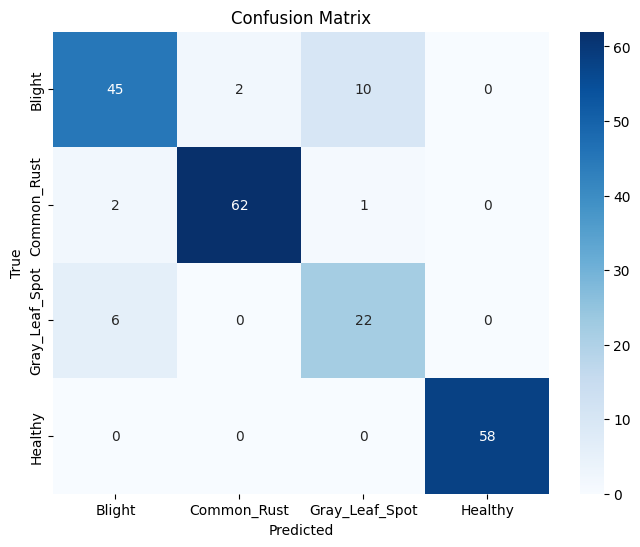


Classification Report:
                precision    recall  f1-score   support

        Blight       0.85      0.79      0.82        57
   Common_Rust       0.97      0.95      0.96        65
Gray_Leaf_Spot       0.67      0.79      0.72        28
       Healthy       1.00      1.00      1.00        58

      accuracy                           0.90       208
     macro avg       0.87      0.88      0.88       208
  weighted avg       0.90      0.90      0.90       208

ROC-AUC Score (OvR): 0.9870


In [6]:
from torchvision import datasets, transforms
from evaluate_model import evaluate_model

test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)
    

evaluate_model(model, testloader=test_loader, test_datasets=test_datasets, device=device)